# Project 2: Banker Helper


Mengyu Jackson

## Overview


A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

Our stakeholder is a mortgage lender who would like more accurate appraisals to reduce risk for home loans. We analyzed the King County (CA) House Sales dataset using machine learning to develop a model for predicting the value of a house. The model accurately predicts the value of a house with information available to the bank at time of appraisal, and would be a good tool for making loan decisions. We recommend using this model along with existing appraisers to reduce risk and increase profit margins.

## Business Problem

1. change the question.
2. features that have bigest impact on price (what's the most importent for price.)
3. 


Our stakeholder is a mortgage lender who wants to increase the accuracy of their appraisals in order to reduce the risk of default, especially loans which have the minimum possible down payment (20%) without Private Mortgage Insurance. These loans are worth 80% of the purchase price of the house. If a borrower defaults immediately, our stakeholder wants confidence they'll be able to re-sell the house and cover the entire loan. At the same time, they do not want artificially low appraisals, as those would drive clients to competing lenders. Specifically, we want to maximize the number of appraisals which are between 80% and 105% of the true value of the house in order to minimize risk while remaining attractive to borrowers.


## Data Understanding

This project uses the King County House Sales dataset, which can be found in `kc_house_data.csv` in the data folder in this repo. The description of the column names can be found in `column_names.md` in the same folder. As with most real world data sets, the column names are not perfectly described, so you'll have to do some research or use your best judgment if you have questions about what the data means.


- Where did the data come from, and how do they relate to the data analysis questions?
    The data come from house sales in King County, and they help us relate all of the features we are interested in (sqft, waterfront, renovated or not)
- What do the data represent? Who is in the sample and what variables are included?
    Only houses that have sold are in the sample, and variables include comparisons to nearby houses (_15 suffixed variables), metrics about the house that was sold and its lot (sqft), whether and when renovations were last done, and the original year it was built.
- What is the target variable?
    The target variable is the sale price of the house. A secondary target could be views; which could be used as a proxy for time-on-market.
- What are the properties of the variables you intend to use?
    Almost all of the variables we intend to use are numeric, except one binary variable (waterfront or not). Some of the variables are cyclic in nature (month), which we hope to capture in our feature selection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import code.preprocessing as prep
import code.visualization as vis
from sklearn.model_selection import train_test_split
from sklearn import datasets, ensemble, linear_model, neural_network
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFECV

# NEW
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor


## Data Preparation

Clean data:
* Id - remove.
* bedroom - replace outlier data. (33 bedrooms to 3)
* Waterfront - guess for Nan Value.
* Date - seperate year, month and day. Try sin/cos for month to cycle twelve months. remove date.
* sqft_living_dif - sqft_living -sqft_living15.
* sqft_lot_dif - sqft_lot - sqft_lot15.
* year_renovated - fill the Nan with the average of the renovated year, add new column 1 or 0 for renovated.
* sqft_basement - replace '?' to None.


Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [2]:
kc_house_data = pd.read_csv('./data/kc_house_data.csv')
copy_data = kc_house_data.copy()
clean_data, target_data = prep.clean_data(copy_data)

### First Model

After decide use sklean, first thing to try is `LinearRegression()`.

In [157]:
prep.model(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

0.7257411230925401

## Modeling

Try different model:

* Ridge(random_state = RANDOM_SEED),
* BayesianRidge(),
* LinearRegression(),
* RandomForestRegressor(random_state = RANDOM_SEED),
* GradientBoostingRegressor(random_state = RANDOM_SEED),
* neural_network.MLPRegressor(solver="lbfgs", random_state = RANDOM_SEED)
* XGBRegressor() 

Use pipline with PCA, PolynomialFeatures or StandardScaler, use GridSearchCV to found the best hyperparameters:



Questions to consider:

- How did you analyze or model the data?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [3]:
RANDOM_SEED = 5
X_train, X_test, y_train, y_test = train_test_split(clean_data, target_data, random_state = RANDOM_SEED)

In [26]:
xg_model= XGBRegressor(learning_rate=0.008, max_depth=6, gamma=0, n_estimators=4000, random_state= RANDOM_SEED)
prep.model(xg_model, X_train, X_test, y_train, y_test)

0.9005361799583668

C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
C:\Users\steve\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:863: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

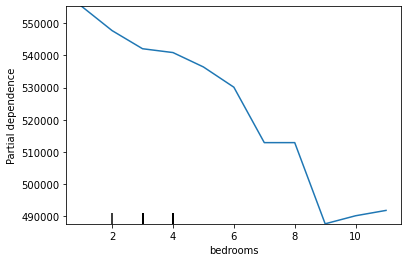

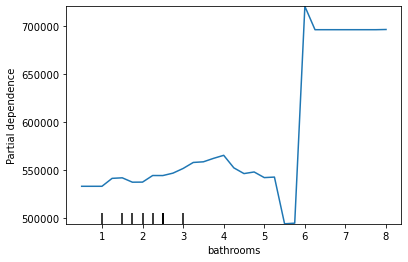

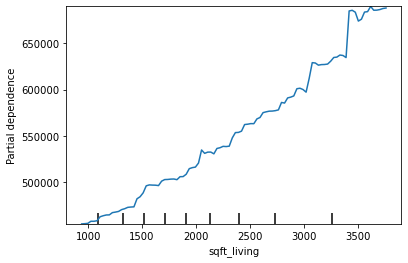

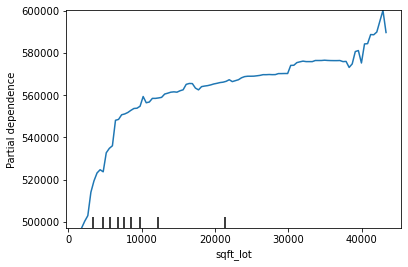

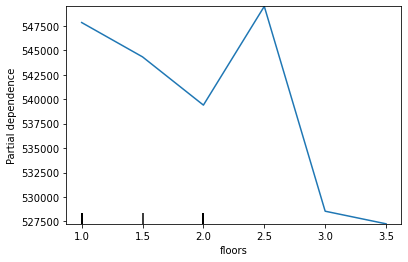

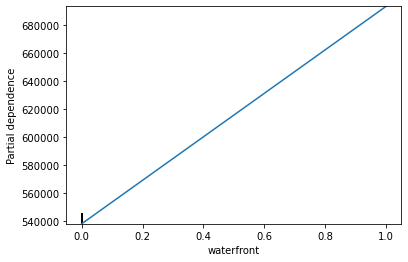

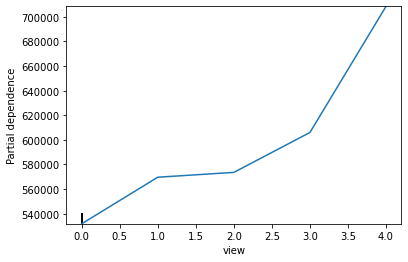

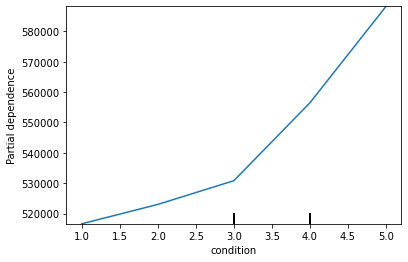

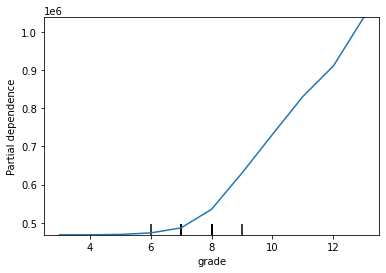

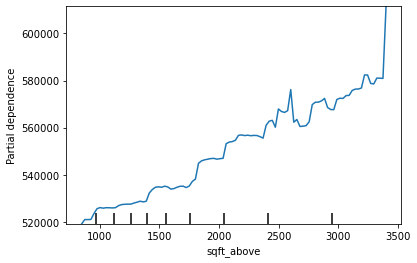

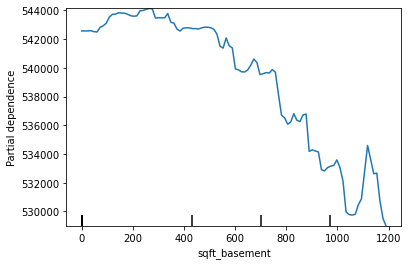

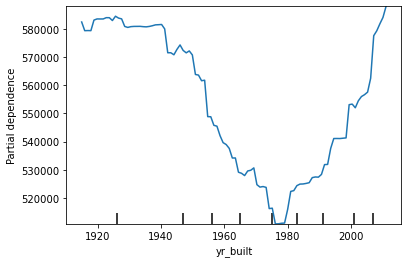

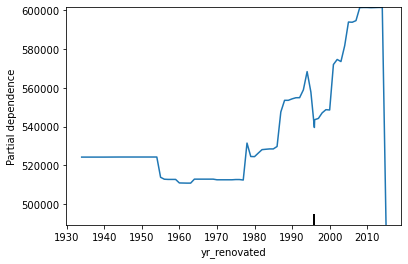

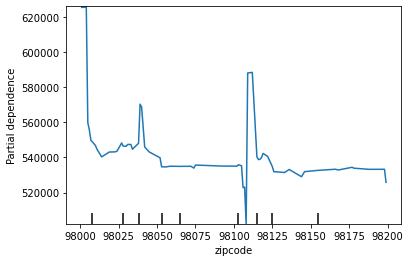

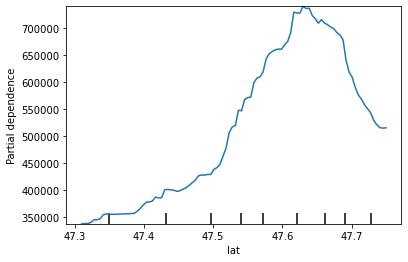

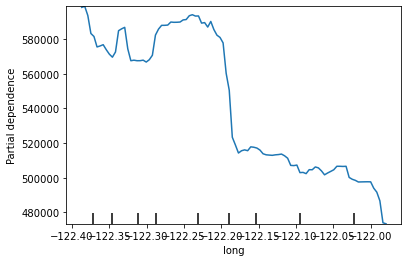

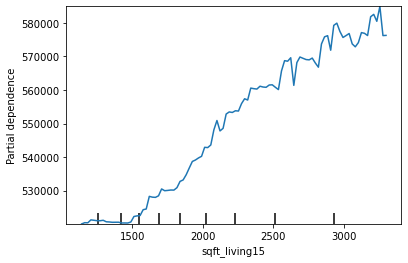

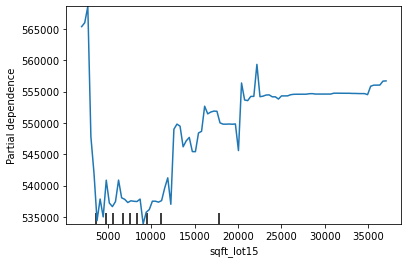

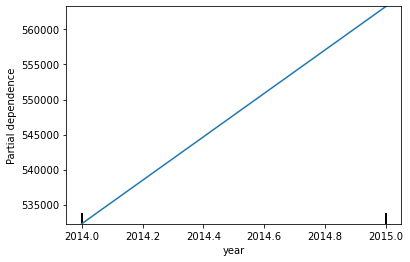

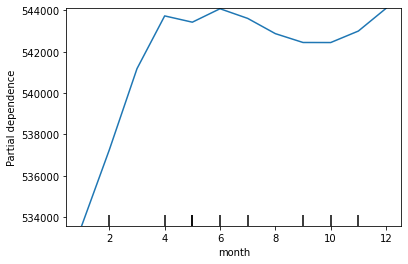

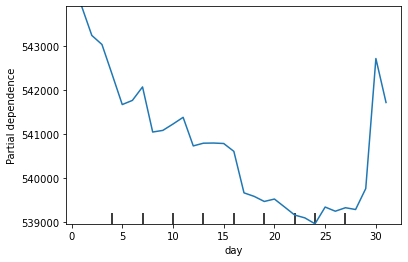

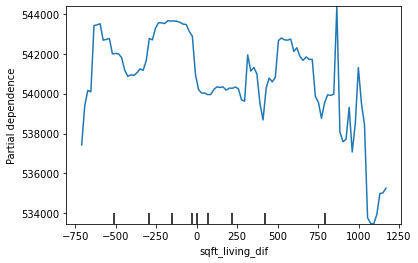

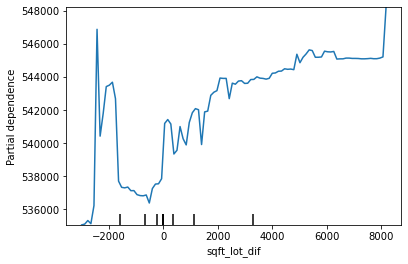

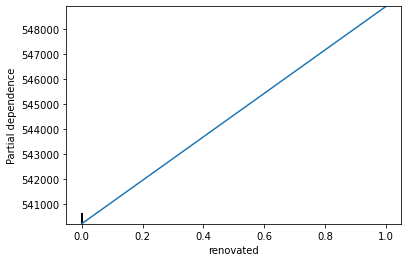

In [8]:
for column in X_train.columns:
    plot_partial_dependence(xg_model, clean_data,  [column])

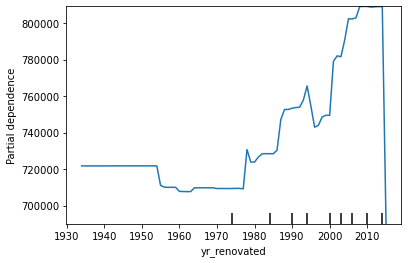

In [18]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_renovated'])

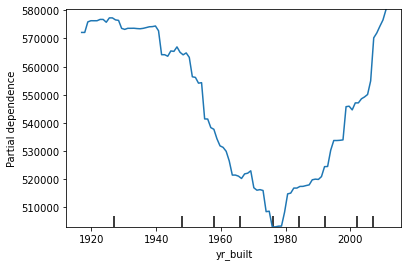

In [15]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==0], ['yr_built'])

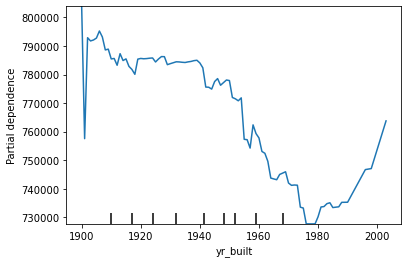

In [16]:
plot_partial_dependence(xg_model, clean_data[clean_data["renovated"]==1], ['yr_built'])

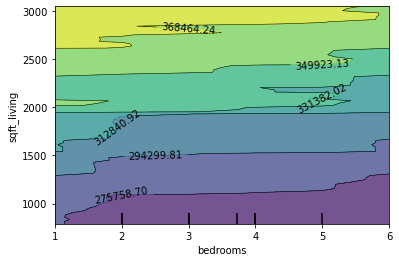

In [76]:
plot_partial_dependence(xg_model, clean_data[clean_data['zipcode'] == 98178], [('bedrooms', 'sqft_living')])

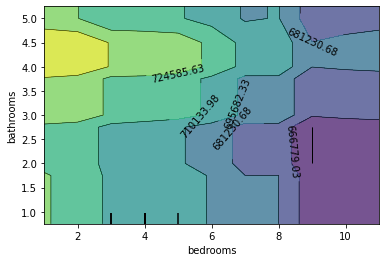

In [81]:
plot_partial_dependence(xg_model, 
                        clean_data[(clean_data['sqft_living'] < 3500) 
                                   & (clean_data['sqft_living'] > 2500)], 
                        [('bedrooms', 'bathrooms')])

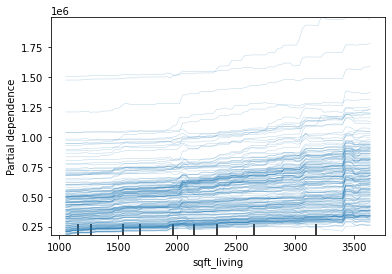

In [159]:
plot_partial_dependence(xg_model, clean_data[:200], ['sqft_living'], kind="individual")

## Evaluation

Evaluate how well your work solves the stated business problem.

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model?
- How well does your model/data fit any modeling assumptions?
- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

Please note - you should be evaluating each model as you move through, and be sure to evaluate your models consistently.

In [103]:
waterfront = (clean_data["waterfront"] == 1)
not_waterfront = (clean_data["waterfront"] == 0)
pred_data = xg_model.predict(clean_data)

In [130]:
low_appraisals = pred_data * .8> target_data
good_appraisals = (pred_data * .8 <= target_data) & (pred_data >= target_data)
high_appraisals = (pred_data < target_data) & (pred_data *1.05 >= target_data)
v_high_appraisals = pred_data *1.05 < target_data

# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
print("Sale Price < 80% of Appraisal (Low Appraisal): ",len(clean_data[low_appraisals]))

# Houses where 100% of appraised value fell short of sale price
# Difficult to find borrowers for these loans
print("Sale Price between 80% and 100% of appraisal (Good Appraisal): ", len(clean_data[good_appraisals]))

# Houses where 100% of appraised value fell short of sale price
# Borrowers will not like these appraisals but may still take them
print("Sale price between 100% and 105% of appraisal (High Appraisal): ", len(clean_data[high_appraisals]))

# Borrowers will probably walk away
print("Sale price over 105% of appriasal (Very High Appraisal): ", len(clean_data[v_high_appraisals]))

Sale Price < 80% of Appraisal (Low Appraisal):  1095
Sale Price between 80% and 100% of appraisal (Good Appraisal):  9914
Sale price between 100% and 105% of appraisal (High Appraisal):  4645
Sale price over 105% of appriasal (Very High Appraisal):  5943


In [156]:
total_low_loans = sum(pred_data[low_appraisals]*.8) 
total_good_loans = sum(pred_data[good_appraisals]*.8)
total_high_loans = sum(pred_data[high_appraisals]*.8)
total_loans = total_low_loans + total_high_loans + total_good_loans
print("Total loans (Low Appraisals): ", total_low_loans)
print("Total loans (Good Appraisals): ", total_good_loans)
print("Total loans (High Appraisals): ", total_high_loans)
print("Total loans (total): ", total_loans)
print()
      
print("Average loan (Low Appraisals): ", total_low_loans/ len(pred_data[low_appraisals]))
print("Average loan (Good Appraisals): ", total_good_loans/ len(pred_data[good_appraisals]))
print("Average loan (High Appraisals): ", total_high_loans/ len(pred_data[high_appraisals]))
print()
      
      
# Houses where 80% of appraised value exceeded sale price
# Risk of losing money if borrowers default on these loans
immediate_default_losses = pred_data[low_appraisals]*.8 - target_data[low_appraisals]
print("Total losses from Low Appraisals (immediate default): ", sum(immediate_default_losses))
print("losses from Low Appraisals (immediate default) as % of total loans : ", sum(immediate_default_losses) * 100/ total_loans)
print("Average loss from Low Appraisals (immediate default): ", sum(immediate_default_losses)/len(immediate_default_losses))
print()

Total loans (Low Appraisals):  392257147.078125
Total loans (Good Appraisals):  4287162792.859375
Total loans (High Appraisals):  2227765951.2265625
Total loans (total):  6907185891.1640625

Average loan (Low Appraisals):  358225.7050941781
Average loan (Good Appraisals):  432435.22219683026
Average loan (High Appraisals):  479605.15634586924

Total losses from Low Appraisals (immediate default):  39360733.078125
losses from Low Appraisals (immediate default) as % of total loans :  0.5698519440236401
Average loss from Low Appraisals (immediate default):  35945.87495719178



In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(target_data, pred_data, squared=False), mean_absolute_error(target_data, pred_data)

(73561.91882407192, 43168.62017728157)

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
